### Author details 

Pratik Antoni Patekar

Pursuing Masters in Computer Science, University of Texas at Arlington

Email: pratik.patekar1123@gmail.com

Mobile: +1 682271274 

# Visual Question Answering (VQA)

Visual Question Answering (VQA) is a Computer Vision task that requires a machine to answer questions about images. This can be a challenging task, as it requires the machine to understand the content of the image, as well as the meaning of the question. 

In this project, two VQA neural network models are developed, one without use of attention layer and another using attention layer. These models can answer questions about images with an accuracy of 49.84% and 28.02% respectively. We will explore these approaches to VQA and evaluate their effectiveness.


## Necessary imports

Let's first import all the packages and libraries that will be required

In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import json
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
import os
import random
from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras import initializers 
from keras.layers import multiply
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,SpatialDropout1D
from keras.optimizers import Adam

## Exploratory Data Analysis

### Train dataset

Let's first check the annotations and questions json files present in the train dataset.

In [2]:
# Define the train_images, annotations and questions path
images_train_path = r".\train_data\images\\"
annotations_train_path = r".\train_data\v2_mscoco_train2014_annotations.json"
questions_train_path = r".\train_data\v2_OpenEnded_mscoco_train2014_questions.json"

annot_data = json.load(open(annotations_train_path))
annot_train = pd.DataFrame(annot_data["annotations"])
annot_train.head()

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
0,what is this,net,"[{'answer': 'net', 'answer_confidence': 'maybe...",458752,other,458752000
1,what,pitcher,"[{'answer': 'pitcher', 'answer_confidence': 'y...",458752,other,458752001
2,what color is the,orange,"[{'answer': 'orange', 'answer_confidence': 'ye...",458752,other,458752002
3,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",458752,yes/no,458752003
4,what color is the,white,"[{'answer': 'white', 'answer_confidence': 'yes...",262146,other,262146000


In [3]:
x = annot_train.groupby('question_type').size()
print("There are " + str(len(x)) + " different question types in the train data set.")
print("And the count of 'how many' question type is " + str(x['how many']) + ".")
print(x.to_string())

There are 65 different question types in the train data set.
And the count of 'how many' question type is 42339.
question_type
are                          4912
are the                     10701
are there                    5877
are there any                2790
are these                    5782
are they                     3074
can you                      1728
could                        1698
do                           3012
do you                       1971
does the                     6103
does this                    4396
has                          1827
how                          4740
how many                    42339
how many people are          4276
how many people are in       2071
is                           6079
is he                        2534
is it                        7345
is that a                    1585
is the                      34927
is the man                   4972
is the person                1694
is the woman                 1938
is there               

In [4]:
annot_train = annot_train[annot_train.question_type == "how many"]
annot_train.head()

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
29,how many,1,"[{'answer': '1', 'answer_confidence': 'yes', '...",393227,number,393227002
36,how many,2,"[{'answer': '2', 'answer_confidence': 'yes', '...",131074,number,131074001
77,how many,3,"[{'answer': '3', 'answer_confidence': 'yes', '...",131093,number,131093002
97,how many,2,"[{'answer': '2', 'answer_confidence': 'yes', '...",25,number,25015
99,how many,2,"[{'answer': '2', 'answer_confidence': 'yes', '...",25,number,25017


There are around 65 different types of questions in the train dataset (we can see above). Out of these we will first try to limit the dataset to only the questions related to counting. So basically we will filter the questions or dataset to the questions starting with "how many".

Let's check the questions json file now.

In [5]:
mcq_data = json.load(open(questions_train_path))
mcq_train = pd.DataFrame(mcq_data["questions"])
mcq_train.head()

,image_id,question,question_id
0,458752,What is this photo taken looking through?,458752000
1,458752,What position is this man playing?,458752001
2,458752,What color is the players shirt?,458752002
3,458752,Is this man a professional baseball player?,458752003
4,262146,What color is the snow?,262146000


Now lets create a dataframe with image path, question and answer

In [6]:
df_dummy = annot_train.merge(mcq_train, how='inner', on='question_id')
df_dummy = df_dummy[['image_id_x', 'question', 'multiple_choice_answer']]
df_dummy.head(10)

,image_id_x,question,multiple_choice_answer
0,393227,How many tattoos can be seen on this man's body?,1
1,131074,How many pieces of furniture which are used fo...,2
2,131093,How many sheeps are this?,3
3,25,How many giraffes are there?,2
4,25,How many animals are in this photo?,2
5,131118,How many planes are in the picture?,2
6,524338,How many trees are in this photo?,3
7,131128,How many flowers are painted on the vase?,3
8,370986,How many elephants are in the water?,2
9,370986,How many tails can you see in this picture?,3


Function to convert the image_id to image name.

In [7]:
def append_zeros(id): # sub function to return img id padded with zeros
    arr = ["0","0","0","0","0","0","0","0","0","0","0","0"]
    count = 0
    for i in range(len(id)-1, -1,-1):
        arr[count] = id[i]
        count += 1
    return "".join(arr[::-1])
    
# Function to return the file name correponding to image id
# if type argument is passed as 't' then return will contain train file name
# else if 'v' is passed then validation file name 
# else error is displayed 
def img_id_2_filename(image_id, type = 't'):
    img_id = str(image_id)
    if type.lower() == 't':
        file_name = "COCO_train2014_"
        s = append_zeros(img_id)
        return file_name + s + ".jpg"
    elif type.lower() == 'v':
        file_name = "COCO_val2014_"
        s = append_zeros(img_id)
        return file_name + s + ".jpg"
    else:
        print("ERROR: Invalid value passed for type argument.")
        return "#ERR"
    

In [8]:
df_train = pd.DataFrame(columns=['image', 'question', 'answer'])
for i in range(len(df_dummy)):
    img_path = images_train_path + img_id_2_filename(df_dummy['image_id_x'].iloc[i])
    quest = df_dummy['question'].iloc[i]
    ans = df_dummy['multiple_choice_answer'].iloc[i]
    df_train.loc[len(df_train)] = [img_path, quest, ans]

print(df_train.size)
df_train.head()

127017


,image,question,answer
0,.\train_data\images\\COCO_train2014_0000003932...,How many tattoos can be seen on this man's body?,1
1,.\train_data\images\\COCO_train2014_0000001310...,How many pieces of furniture which are used fo...,2
2,.\train_data\images\\COCO_train2014_0000001310...,How many sheeps are this?,3
3,.\train_data\images\\COCO_train2014_0000000000...,How many giraffes are there?,2
4,.\train_data\images\\COCO_train2014_0000000000...,How many animals are in this photo?,2


Now let's check the data in the dataframe and validate the question, answer and image. 

Image path: .\train_data\images\\COCO_train2014_000000539051.jpg
Image size: (428, 640, 3)


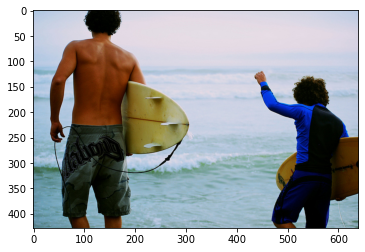

How many surfboards are there?
2


In [9]:
row_no = random.randint(0, len(df_train)) # enter row no from 0 to 59999
# this will plot the image, print a question from mcq df and answer from annot df
img_name = df_train.iloc[row_no]['image']
image = Image.open(os.path.join(img_name))
print("Image path: " + img_name)
print("Image size: " + str(np.asarray(image).shape))
plt.imshow(image)
plt.show()

print(df_train.iloc[row_no]["question"])
print(df_train.iloc[row_no]["answer"])


### Validation dataset

Let's do similar EDA for validation dataset as well.

In [10]:
# Define the val_images, annotations and questions path
images_val_path = r".\val_data\images\\"
annotations_val_path = r".\val_data\v2_mscoco_val2014_annotations.json"
questions_val_path = r".\val_data\v2_OpenEnded_mscoco_val2014_questions.json"

annot_data = json.load(open(annotations_val_path))
annot_val = pd.DataFrame(annot_data["annotations"])
annot_val.head()

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
0,none of the above,down,"[{'answer': 'down', 'answer_confidence': 'yes'...",262148,other,262148000
1,what are the,watching,"[{'answer': 'spectating', 'answer_confidence':...",262148,other,262148001
2,what is,picnic table,"[{'answer': 'table', 'answer_confidence': 'yes...",262148,other,262148002
3,what,foodiebakercom,"[{'answer': 'foodiebakercom', 'answer_confiden...",393225,other,393225000
4,is this a,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",393225,yes/no,393225001


In [11]:
x = annot_val.groupby('question_type').size()
print("There are " + str(len(x)) + " different question types in the validation data set.")
print("And the count of 'how many' question type is " + str(x['how many']) + ".")
print(x.to_string())

There are 65 different question types in the validation data set.
And the count of 'how many' question type is 20462.
question_type
are                          2359
are the                      5264
are there                    2771
are there any                1330
are these                    2839
are they                     1335
can you                       872
could                         618
do                           1503
do you                        724
does the                     3183
does this                    2227
has                           946
how                          2422
how many                    20462
how many people are          2005
how many people are in        905
is                           3169
is he                        1087
is it                        3566
is that a                     714
is the                      17265
is the man                   2511
is the person                 794
is the woman                  992
is there          

In [12]:
annot_val = annot_val[annot_val.question_type == "how many"]
annot_val.head()

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
8,how many,1,"[{'answer': '1', 'answer_confidence': 'maybe',...",393226,number,393226001
15,how many,1,"[{'answer': '1', 'answer_confidence': 'yes', '...",131089,number,131089002
19,how many,1,"[{'answer': '1', 'answer_confidence': 'yes', '...",262162,number,262162001
21,how many,7,"[{'answer': '7', 'answer_confidence': 'yes', '...",262162,number,262162003
23,how many,1,"[{'answer': '1', 'answer_confidence': 'maybe',...",262162,number,262162005


In [13]:
mcq_data = json.load(open(questions_val_path))
mcq_val = pd.DataFrame(mcq_data["questions"])
mcq_val.head()

,image_id,question,question_id
0,262148,Where is he looking?,262148000
1,262148,What are the people in the background doing?,262148001
2,262148,What is he on top of?,262148002
3,393225,What website copyrighted the picture?,393225000
4,393225,Is this a creamy soup?,393225001


In [14]:
df_dummy = annot_val.merge(mcq_val, how='inner', on='question_id')
df_dummy = df_dummy[['image_id_x', 'question', 'multiple_choice_answer']]
df_dummy.head(10)

,image_id_x,question,multiple_choice_answer
0,393226,How many photo's can you see?,1
1,131089,How many are playing ball?,1
2,262162,How many beds?,1
3,262162,How many pictures are there?,7
4,262162,How many sources of light are there?,1
5,262162,How many chairs are in the photo?,1
6,262162,How many seats are there?,1
7,262162,How many frames are on the wall?,7
8,262162,How many pictures on the wall?,7
9,262189,How many signs?,4


In [15]:
df_val = pd.DataFrame(columns=['image', 'question', 'answer'])
for i in range(len(df_dummy)):
    img_path = images_val_path + img_id_2_filename(df_dummy['image_id_x'].iloc[i], 'v')
    quest = df_dummy['question'].iloc[i]
    ans = df_dummy['multiple_choice_answer'].iloc[i]
    df_val.loc[len(df_val)] = [img_path, quest, ans]

print(df_val.size)
df_val.head()

61386


,image,question,answer
0,.\val_data\images\\COCO_val2014_000000393226.jpg,How many photo's can you see?,1
1,.\val_data\images\\COCO_val2014_000000131089.jpg,How many are playing ball?,1
2,.\val_data\images\\COCO_val2014_000000262162.jpg,How many beds?,1
3,.\val_data\images\\COCO_val2014_000000262162.jpg,How many pictures are there?,7
4,.\val_data\images\\COCO_val2014_000000262162.jpg,How many sources of light are there?,1


Image path: .\val_data\images\\COCO_val2014_000000565031.jpg
Image size: (480, 640, 3)


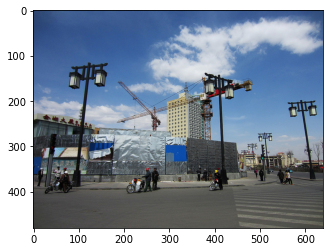

How many light posts are visible?
3


In [16]:
row_no = random.randint(0, len(df_val))
# this will plot the image, print a question from mcq df and answer from annot df
img_name = df_val.iloc[row_no]['image']
image = Image.open(os.path.join(img_name))
print("Image path: " + img_name)
print("Image size: " + str(np.asarray(image).shape))
plt.imshow(image)
plt.show()

print(df_val.iloc[row_no]["question"])
print(df_val.iloc[row_no]["answer"])


In [17]:
df_val.describe()

,image,question,answer
count,20462,20462,20462
unique,14357,6959,118
top,.\val_data\images\\COCO_val2014_000000005754.jpg,How many animals are there?,1
freq,14,141,5191


## Tokenizer for LSTM input

As mentioned in the project report, this project uses the LSTM model to convert and extract features from the question input which is in string format. As the questions are in string format, they cannot be directly fed to the LSTM model. This requires tokenization of every question string using an encoder. As already mentioned, this project uses VGG16 as an image encoder which is already available. Similarly, there are many readily available tokenizers and encoders such as BERT. But here we have built a tokenization method from scratch to have more control over what words will be tokenized as what and how the symbols in the question are taken care of.

For example, as per our encoding method, the word ‘countertops’ is encoded as an integer ‘1000’. 

In [18]:
max_len = 0
for i in df_train['question'].values:
    if len(i.split(" ")) > max_len:
        max_len = len(i.split(" "))

print(max_len)

19


In [19]:
def ques_equivate_len(ques_arr):
    ret_arr = []
    for i in range(18):
        try:
            if ques_arr[i] != " ":
                ret_arr.append(ques_arr[i])
            else:
                ret_arr.append("#")
        except:
            ret_arr.append("#")
    return ret_arr

In [20]:
# create a set of all words from questions and multiple choices 
mcq_train_questions = df_train['question'].values
mcq_train_choices = df_train['answer'].drop_duplicates().values
#print(mcq_train_choices)

some_set = set()
for some_question in mcq_train_questions:
    words = some_question.lower().split(" ")
    for i in words:
        some_set.add(i)

print(len(some_set))

for ans in mcq_train_choices:
    some_set.add(ans)
print(len(some_set))

some_set.add("#")
#some_set.add(" ")
#some_set.add("w")

print(len(some_set))

some_list = list(some_set)
some_list.sort()

4157
4285
4286


In [21]:
int_to_word = {}
word_to_int = {}
for int1 in range(len(some_list)):
  word = some_list[int1]
  int_to_word[int1] = word
  word_to_int[word] = int1

In [22]:
int_to_word[1000]

'countertops'

In [23]:
word_to_int['countertops']

1000

In [24]:
answer_list = df_train['answer'].drop_duplicates().values

## Image encoder

This project uses VGG16 neural network model to encode all the images. Any given input image is first encoded using VGG16 model (using some pretrianed ImageNet weights).

In [25]:
def read_image(image_name):
    image = Image.open(os.path.join(image_name))
    image = image.convert('RGB')  # convert images to RGB as some are in RGBA format
    my_arr = np.asarray(image.resize((224,224))) / 255.0  # resize and normalize
    return my_arr[None, :]

In [26]:
vgg_model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
VGG16Model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [28]:
VGG16Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
row_no = 502 # enter row no from 0 to 59999
img_name = df_train.iloc[row_no]['image']
image = read_image(img_name)
encoded_image = VGG16Model.predict(image)
print(encoded_image.shape)

1/1 [==============================] - 1s 655ms/step
(1, 4096)


In [28]:
# collect all unique image file names 
file_names_train = df_train["image"].drop_duplicates().values

In [29]:
def img_generator(img_list):
    for img in img_list:
        #out_image = np.expand_dims(read_image(img), axis=0)
        out_image = read_image(img)
        yield out_image

In [32]:
enc_train = VGG16Model.predict(img_generator(file_names_train), steps=len(file_names_train), verbose=1)

29255/29255 [==============================] - 6120s 209ms/step


In [ ]:
print(enc_train.shape)
np.save("encoded_images_train_VGG.npy", enc_train)

In [30]:
enc_train = np.load("encoded_images_train_VGG.npy")

## Generator function for training the final model

In [31]:
def convert_to_numbers(string_arr):
    return [word_to_int[i] for i in string_arr]

def convert_to_words(num_arr):
    return [int_to_word[i] for i in num_arr]

def generator_func(ans_list=answer_list, batch_size = 128):
    bcount = 0
    ques = []
    image = []
    answer = []

    while True:
        for i in range(len(df_train)):
            img_name = df_train['image'].iloc[i]
            
            ques_string = df_train['question'].iloc[i]
            ques_string = np.asarray(convert_to_numbers(ques_equivate_len(ques_string.lower().split(" "))))

            answ = df_train['answer'].iloc[i]
            #print(answer_string)
            answer_string = np.zeros(144)
            #print(ans_list)
            for i in range(144):
                if ans_list[i] == answ:
                    answer_string[i] = 1
            #print(answer_string)


            #print(img_name, ques_string, answer_string)
            enc_img_ind = np.where(file_names_train == img_name)[0][0]
            enc_image = enc_train[enc_img_ind]
            ques.append(ques_string)
            image.append(enc_image)
            answer.append(answer_string)
            bcount += 1

            if bcount >= batch_size:
                yield [[np.asarray(image), np.asarray(ques)], np.asarray(answer)]
                ques = []
                image = []
                answer = []
                bcount = 0

## Image model

In [32]:
#Creating image model 
img_in = Input(shape=(4096,))
train_image=Dense(1024,activation='relu')(img_in)
train_image=Model(inputs=img_in,outputs=train_image)
train_image.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 1024)              4195328   
                                                                 
Total params: 4,195,328
Trainable params: 4,195,328
Non-trainable params: 0
_________________________________________________________________


## LSTM model

In [33]:
vocab_len = len(word_to_int)
QUES_MAX_LEN = 18

#Lstm model for Questions
ques_in = Input(shape=(QUES_MAX_LEN,))
embedding1 =Embedding(vocab_len, 300, input_length=QUES_MAX_LEN,trainable=False)(ques_in)
lone= LSTM(64,return_sequences=True)(embedding1)
ltwo= LSTM(64,return_sequences=True)(lone)
flat = Flatten(name='flatten_1')(ltwo)
ques_model=Dense(1024,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(flat)
ques_model = Model(inputs=ques_in, outputs=ques_model)
ques_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding (Embedding)       (None, 18, 300)           1285800   
                                                                 
 lstm (LSTM)                 (None, 18, 64)            93440     
                                                                 
 lstm_1 (LSTM)               (None, 18, 64)            33024     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1180672   
                                                                 
Total params: 2,592,936
Trainable params: 1,307,136
Non-tra

## Fusion model (multiply based fusion method)

In [34]:
#Fusion model
fusion_model = multiply([train_image.layers[-1].output,ques_model.layers[-1].output])
dnn1 = BatchNormalization()(fusion_model)
dnn1 = Dropout(0.5)(dnn1)
dnn1 = Dense(1000,activation='relu',kernel_initializer=initializers.he_normal(seed=42))(dnn1)
CombinedOutput = Dense(144, kernel_initializer=initializers.he_normal(seed=42),activation='softmax')(dnn1)
FinalModel = Model(inputs=[img_in,ques_in], outputs=CombinedOutput)
print(FinalModel.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 18, 300)      1285800     ['input_3[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 18, 64)       93440       ['embedding[0][0]']              
                                                                                                  
 lstm_1 (LSTM)                  (None, 18, 64)       33024       ['lstm[0][0]']                   
                                                                                            

In [35]:
print(len(answer_list))

144


## Training the multiply based fusion model

In [36]:
FinalModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 
batch_size = 128
generator = generator_func(answer_list, batch_size)
steps = len(file_names_train) * QUES_MAX_LEN // batch_size 

In [46]:
hist = FinalModel.fit(generator, steps_per_epoch=steps, epochs=2, verbose=1)

Epoch 1/2
4113/4113 [==============================] - 641s 156ms/step - loss: 1.3796 - accuracy: 0.4876
Epoch 2/2
4113/4113 [==============================] - 719s 175ms/step - loss: 1.3501 - accuracy: 0.4984


In [115]:
FinalModel.save_weights("VQA_model_weights_VGG.h5") # acquired 28.29% accuracy in just 1 epoch

In [140]:
FinalModel.save_weights("VQA_model_weights_VGG_v2.h5") # acquired 33.16% accuracy in 3 epochs total

In [166]:
FinalModel.save_weights("VQA_model_weights_VGG_v3.h5") # acquired 40.25% accuracy in 7 epochs total

In [177]:
FinalModel.save_weights("VQA_model_weights_VGG_v4.h5") # acquired 42.96% accuracy in 9 epochs total

In [43]:
FinalModel.save_weights("VQA_model_weights_VGG_v5.h5") # acquired 45.54% accuracy in 11 epochs total

In [45]:
FinalModel.save_weights("VQA_model_weights_VGG_v6.h5") # acquired 45.54% accuracy in 13 epochs total

In [47]:
FinalModel.save_weights("VQA_model_weights_VGG_v7.h5") # acquired 49.84% accuracy in 15 epochs total

In [37]:
FinalModel.load_weights("VQA_model_weights_VGG_v7.h5")

## Decoder function to print the prediction of the model

In [38]:
def decode(enc_img, tokenized_ques, tokenized_choices):
    # write code
    pred = FinalModel.predict([enc_img, tokenized_ques])
    arr = []
    for i in range(144):
        arr.append(pred[0,i])
    pd_prob = pd.DataFrame({'Answer': tokenized_choices, 'Prob': arr})
    pd_prob = pd_prob.sort_values('Prob',ascending=False)
    print("Predicted answer: ", pd_prob['Answer'].iloc[0])
    print("\nBelow are the top 4 predicted answers:")
    print(pd_prob[:4].to_string(index=False))
    return pred
    

In [39]:
print(len(answer_list))
print(int_to_word[15])

144
#


In [40]:
print(len(file_names_train))

29255


## Results of Multiply based fusion model

### Training dataset results

Question: How many species of animals are in the picture?
Actual answer: 2


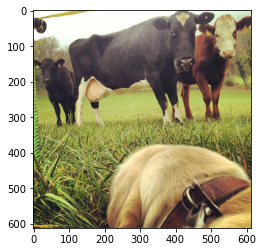

1/1 [==============================] - 0s 31ms/step
Predicted answer:  2

Below are the top 4 predicted answers:
Answer     Prob
     2 0.934701
     1 0.060222
     3 0.005043
     4 0.000034


In [57]:
rand_ind = random.randint(0,29254)
ind_p = 0 # 0 or 1 or 2
img1 = np.asarray([enc_train[rand_ind]])
#ques_string = convert_to_numbers(ques_equivate_len(ques_string.lower().split(" ")))
print("Question:", df_train[df_train['image'] == file_names_train[rand_ind]]['question'].iloc[0])
print("Actual answer:", df_train[df_train['image'] == file_names_train[rand_ind]]['answer'].iloc[0])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_train[df_train['image'] == file_names_train[rand_ind]]['question'].iloc[0].lower().split(" ")))])
ans = np.asarray([convert_to_numbers([df_train[df_train['image'] == file_names_train[rand_ind]]['answer'].iloc[0]])])

image = Image.open(os.path.join(file_names_train[rand_ind]))
plt.imshow(image)
plt.show()

features = decode(img1, ques, answer_list)


### Testing on validation dataset

Here I have tried here asking any random questions regarding count to the modelwith respect to random images from the validation dataset. 

Random image number: 7079


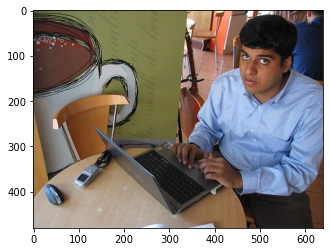

Question asked: how many people are there?
1/1 [==============================] - 0s 40ms/step
Predicted answer:  2

Below are the top 4 predicted answers:
Answer     Prob
     2 0.582986
     1 0.196790
     4 0.104128
     3 0.081163


In [55]:
rand_ind = random.randint(0,20461)
print("Random image number: " + str(rand_ind))
img_name = df_val.iloc[rand_ind]['image']
image = Image.open(os.path.join(img_name))
plt.imshow(image)
plt.show()
try:
    ques_in1 = input("Question: ")
    ques = np.asarray([convert_to_numbers(ques_equivate_len(ques_in1.lower().split(" ")))])
    print("Question asked: " + ques_in1)

    img_name = df_val.iloc[rand_ind]['image']
    image = read_image(img_name)
    img1 = VGG16Model.predict(image)

    decode(img1, ques, answer_list)
except Exception as err:
    print("ERROR: Some of the words entered in the questions are not present in the dictionary.")
    print(err)

## Model with attention based fusion method

Below is a varient of the model created above. The fusion method has been changed to attention instead of multiply.

In [43]:
import tensorflow as tf
from keras import regularizers
from keras.layers import Attention

# Create the image model.
img_in = Input(shape=(4096,))
train_image = Dense(1024, activation='relu')(img_in)
train_image = Model(inputs=img_in, outputs=train_image)

# Create the question model.
ques_in = Input(shape=(QUES_MAX_LEN,))
embedding1 = Embedding(vocab_len, 300, input_length=QUES_MAX_LEN, trainable=False)(ques_in)
lst1 = LSTM(64, kernel_initializer=initializers.he_normal(seed=42), kernel_regularizer=regularizers.l2(0.001), return_sequences=True)(embedding1)
lst2 = LSTM(64, kernel_initializer=initializers.he_normal(seed=42), kernel_regularizer=regularizers.l2(0.001), return_sequences=True)(lst1)
flat = Flatten(name='flatten_1')(lst2)
ques_model = Dense(1024, activation='relu', kernel_initializer=initializers.he_normal(seed=42))(flat)
ques_model = Model(inputs=ques_in, outputs=ques_model)

# Create the attention layer.
attention = Attention()([train_image.output, ques_model.output])

# Create the final layer of the model.
combined = Dense(1000, activation='relu', kernel_initializer=initializers.he_normal(seed=42))(attention)
CombinedOutput = Dense(144, kernel_initializer=initializers.he_normal(seed=42), activation='softmax')(combined)

# Create the final model.
attention_model = Model(inputs=[img_in, ques_in], outputs=CombinedOutput)

# Print the summary of the model.
attention_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 18, 300)      1285800     ['input_5[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 18, 64)       93440       ['embedding_1[0][0]']            
                                                                                                  
 lstm_3 (LSTM)                  (None, 18, 64)       33024       ['lstm_2[0][0]']                 
                                                                                            

In [51]:
tf.keras.utils.plot_model(attention_model, to_file='attention_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Training the model

In [45]:
attention_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 
batch_size = 128
generator = generator_func(answer_list, batch_size)
steps = len(file_names_train) * QUES_MAX_LEN // batch_size 

In [180]:
hist = attention_model.fit(generator, steps_per_epoch=steps, epochs=4, verbose=1)

Epoch 1/4
4113/4113 [==============================] - 998s 243ms/step - loss: 2.2227 - accuracy: 0.2707
Epoch 2/4
4113/4113 [==============================] - 1422s 346ms/step - loss: 2.2074 - accuracy: 0.2748
Epoch 3/4
4113/4113 [==============================] - 1368s 332ms/step - loss: 2.1959 - accuracy: 0.2775
Epoch 4/4
4113/4113 [==============================] - 1347s 327ms/step - loss: 2.1868 - accuracy: 0.2802


In [86]:
attention_model.save_weights("VQA_model_weights_VGG_attention.h5") # acquired IDK% accuracy in just 1 epoch

In [181]:
attention_model.save_weights("VQA_model_weights_VGG_attention_v2.h5") # acquired 28.02% accuracy in just 5 epoch

In [46]:
attention_model.load_weights("VQA_model_weights_VGG_attention_v2.h5")

### Decoder function for attention based fusion model

In [47]:
def decode_attention(enc_img, tokenized_ques, tokenized_choices):
    # write code
    pred = attention_model.predict([enc_img, tokenized_ques])
    arr = []
    for i in range(144):
        arr.append(pred[0,i])
    pd_prob = pd.DataFrame({'Answer': tokenized_choices, 'Prob': arr})
    pd_prob = pd_prob.sort_values('Prob',ascending=False)
    print("Predicted answer: ", pd_prob['Answer'].iloc[0])
    print("\nBelow are the top 4 predicted answers:")
    print(pd_prob[:4].to_string(index=False))
    return pred
    

In [48]:
attention_layer_output = Model(inputs=[img_in, ques_in], outputs=[attention_model.output, attention])

Function to give the output of the attention layer

In [49]:
def plot_attention_map(img_input, ques_input):
  # Get the prediction and attention output from the model.
  prediction, attention_output = attention_layer_output.predict([img_input, ques_input])
  # Reshape the attention output to a 2D matrix.
  attention_matrix = np.reshape(attention_output, (32, 32))
  # Plot the attention map as a heatmap.
  plt.figure(figsize=(8, 8))
  plt.imshow(attention_matrix)
  plt.title('Attention Map')
  plt.show()
  return attention_matrix

Random index number: 16165
How many horses are there?
2


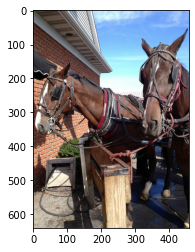

1/1 [==============================] - 0s 23ms/step
Predicted answer:  2

Below are the top 4 predicted answers:
Answer     Prob
     2 0.341368
     1 0.296551
     3 0.140733
     4 0.079232
1/1 [==============================] - 0s 29ms/step


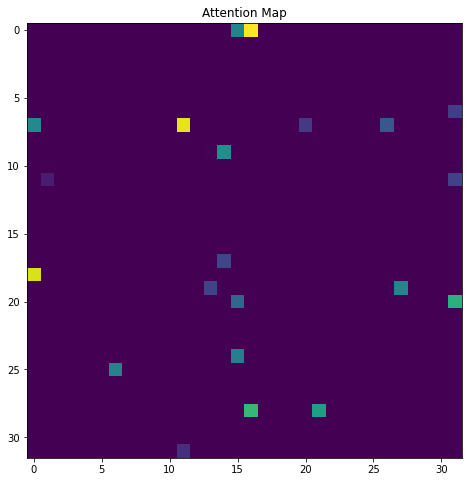

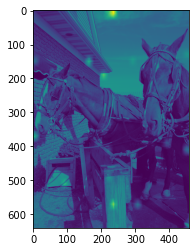

In [69]:
rand_ind = random.randint(0,29254)
print("Random index number:", rand_ind)
# rand_ind = 1
ind_p = 0 # 0 or 1 or 2
img1 = np.asarray([enc_train[rand_ind]])
#ques_string = convert_to_numbers(ques_equivate_len(ques_string.lower().split(" ")))
print(df_train[df_train['image'] == file_names_train[rand_ind]]['question'].iloc[0])
print(df_train[df_train['image'] == file_names_train[rand_ind]]['answer'].iloc[0])
ques = np.asarray([convert_to_numbers(ques_equivate_len(df_train[df_train['image'] == file_names_train[rand_ind]]['question'].iloc[0].lower().split(" ")))])
ans = np.asarray([convert_to_numbers([df_train[df_train['image'] == file_names_train[rand_ind]]['answer'].iloc[0]])])

image = Image.open(os.path.join(file_names_train[rand_ind]))
plt.imshow(image)
plt.show()

output = decode_attention(img1, ques, answer_list)

# Plot the attention map for the sample inputs.
attention_matrix = plot_attention_map(img1, ques)
attention_matrix = cv2.resize(attention_matrix,image.size, cv2.INTER_CUBIC)
attention_matrix = attention_matrix/attention_matrix.max()

image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
image = image/image.max()
new_attention_image = image + attention_matrix
plt.imshow(new_attention_image)
plt.show()
